# 참고

코랩 환경에서 작성된 코드입니다.

데이터셋
- https://github.com/bab2min/corpus/tree/master/sentiment
- https://github.com/e9t/nsmc
- https://github.com/ko-nlp/Korpora

모델
- https://github.com/kiyoungkim1/LMkor
- https://github.com/SKTBrain/KoBERT
- https://github.com/monologg/KoBERT-Transformers

DOCS
- https://huggingface.co/docs/transformers/training
- https://wikidocs.net/44249
- https://arxiv.org/pdf/1810.04805.pdf (https://mino-park7.github.io/nlp/2018/12/12/bert-%EB%85%BC%EB%AC%B8%EC%A0%95%EB%A6%AC/)
- https://arxiv.org/pdf/2006.04884.pdf (https://chloelab.tistory.com/33)

# 라이브러리 로드

In [ ]:
from IPython.display import clear_output 

!pip install transformers
!pip install tensorflow_addons

clear_output()

In [ ]:
import re
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from transformers import BertTokenizerFast, TFBertModel

import tensorflow as tf
import tensorflow_addons as tfa

from tqdm import tqdm


ROOT_PATH = '/content/drive/MyDrive/Project/DL'

DATASET_PATH = ROOT_PATH + '/data'
CHECKPOINT_PATH = ROOT_PATH + '/saved_models'
MODEL_PATH = CHECKPOINT_PATH
CACHE_PATH = ROOT_PATH + '/cache'


def init_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)


init_dir(DATASET_PATH)
init_dir(CHECKPOINT_PATH)
init_dir(MODEL_PATH)
init_dir(CACHE_PATH)

# 데이터 로드

In [ ]:
!wget https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt -O corpus_naver_shopping.txt
!wget https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt -O corpus_steam.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt -O corpus_naver_movie.txt

!mv corpus*.txt '{DATASET_PATH}'

clear_output()

In [ ]:
df_1 = pd.read_table(DATASET_PATH + '/corpus_naver_shopping.txt', names=['label', 'content'])
df_1['label'] = df_1['label'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
df_2 = pd.read_table(DATASET_PATH + '/corpus_steam.txt', names=['label', 'content'])

In [ ]:
df_3 = pd.read_table(DATASET_PATH + '/corpus_naver_movie.txt', names=['id', 'content', 'label'])
df_3 = df_3[1:]
df_3 = df_3[['content', 'label']]

In [ ]:
df = pd.concat([df_1, df_2, df_3])
df = df.drop_duplicates('content')
df = df.reset_index(drop=True)
df = df.astype({'label': np.uint8})
df = df.dropna()

In [ ]:
df.shape

(493987, 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.3, random_state=0xC0FFEE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((345790,), (148197,), (345790,), (148197,))

# 텍스트 데이터 전처리

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base', cache_dir=CACHE_PATH)

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

In [ ]:
# print(tokenizer.get_vocab())

In [ ]:
print(tokenizer.tokenize('사전 학습된 토크나이저에 대한 테스트입니다.'))

['사전', '학습', '##된', '토크', '##나이', '##저', '##에', '대한', '테스트', '##입니다', '.']


In [ ]:
print(tokenizer.encode('사전 학습된 토크나이저에 대한 테스트입니다.'))

[2, 17878, 16784, 8544, 30605, 20491, 8255, 8008, 14083, 15682, 13992, 2016, 3]


In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenizer.encode('사전 학습된 토크나이저에 대한 테스트입니다.')))

['[CLS]', '사전', '학습', '##된', '토크', '##나이', '##저', '##에', '대한', '테스트', '##입니다', '.', '[SEP]']


In [ ]:
df['content'].str.len().sort_values(ascending=False)[:5]

373223    142
443320    140
40940     140
449034    140
422765    140
Name: content, dtype: int64

In [ ]:
len(tokenizer.tokenize(df['content'][443320]))

70

In [ ]:
tokenizer.encode_plus('사전 학습된 토크나이저에 대한 테스트입니다.', max_length=30, padding='max_length')

{'input_ids': [2, 17878, 16784, 8544, 30605, 20491, 8255, 8008, 14083, 15682, 13992, 2016, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
SEQ_LEN = 128 # 최대 token 개수 이상의 값으로 임의로 설정

token_ids =[]
token_masks =[]
token_segments =[]

train_labels = []


for idx in tqdm(range(len(X_train))):
  
  train_sentence = X_train.iloc[idx]
    
  # 특수문자 제거
  cleaned_sentence = re.sub('[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', '', train_sentence)

  # Tokenizing / Tokens to sequence numbers / Padding
  encoded_dict = tokenizer.encode_plus(text=cleaned_sentence,
                                       padding='max_length', 
                                       truncation = True,
                                       max_length=SEQ_LEN)

  token_ids.append(encoded_dict['input_ids']) # tokens_tensor
  token_masks.append(encoded_dict['attention_mask']) # masks_tensor
  token_segments.append(encoded_dict['token_type_ids']) # segments_tensor

  train_labels.append(y_train.iloc[idx])


train_inputs = (np.array(token_ids), np.array(token_masks), np.array(token_segments))
train_labels = np.array(train_labels)

100%|██████████| 345790/345790 [01:24<00:00, 4074.86it/s]


In [ ]:
train_inputs[0]

array([[    2, 22724, 13970, ...,     0,     0,     0],
       [    2,  7465, 14783, ...,     0,     0,     0],
       [    2,  2120,  8402, ...,     0,     0,     0],
       ...,
       [    2,  4886, 26227, ...,     0,     0,     0],
       [    2, 14600, 30245, ...,     0,     0,     0],
       [    2, 16476,  8120, ...,     0,     0,     0]])

In [ ]:
print(train_inputs[0][1]) # tokens_tensor
print(train_inputs[1][1]) # masks_tensor 
print(train_inputs[2][1]) # segments_tensor
print(tokenizer.decode(train_inputs[0][1])) # Re-constructed sentence

[    2  7465 14783 14005  6169  8399 32020     3     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# 모델링

In [ ]:
def create_model(max_length):
  base_model = TFBertModel.from_pretrained('kykim/bert-kor-base', cache_dir=CACHE_PATH, from_pt=True)

  input_token_ids   = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='input_token_ids')   # tokens_tensor
  input_masks       = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='input_masks')       # masks_tensor
  input_segments    = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='input_segments')    # segments_tensor  

  bert_outputs = base_model([input_token_ids, input_masks, input_segments]) 
  
  bert_outputs = bert_outputs[1] # ('pooler_output', <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>)
  bert_outputs = tf.keras.layers.Dropout(0.2)(bert_outputs)
  final_output = tf.keras.layers.Dense(units=2,
                                       activation='softmax', 
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), 
                                       name='classifier')(bert_outputs)

  model = tf.keras.Model(inputs=[input_token_ids, input_masks, input_segments], 
                         outputs=final_output)
  
  model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=1e-5, weight_decay=0.0025, warmup_proportion=0.05),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
# TPU 세팅 (TPU 클러스터 할당 & 초기화)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print('All devices: ', tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver) # Obsolete : tf.distribute.experimental.TPUStrategy()

with strategy.scope(): 
  model = create_model(max_length=SEQ_LEN) # TPU Cluster 상에서 모델 생성 & Compile 진행

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.31.183.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.183.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  118297344   ['input_token_ids[0][0]',        
                                thPoolingAndCrossAt               'input_masks[0][0]',        

# 모델 학습

In [ ]:
# For custom models, we have to use "save_weights_only = True" (or we should implement a "get_config" method @ https://j.mp/3ltUibd) 
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH + '/best_weights.h5',
                                                         monitor='val_sparse_categorical_accuracy',
                                                         save_best_only=True, 
                                                         save_weights_only = True, 
                                                         verbose=1)

# Early-stopping for preventing the overfitting
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                                      min_delta=0.0001, # the threshold that triggers the termination (acc should at least improve 0.0001)
                                                      patience=5) #  Number of epochs with no improvement after which training will be stopped

In [ ]:
history = model.fit(train_inputs, train_labels, validation_split=0.2,
                    epochs=100, batch_size=16,
                    verbose=1,
                    callbacks=[callback_checkpoint, callback_earlystop])

Epoch 1/100
17290/17290 [==============================] - ETA: 0s - loss: 0.2695 - sparse_categorical_accuracy: 0.8880
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.90332, saving model to /content/drive/MyDrive/Project/DL/saved_models/best_weights.h5
17290/17290 [==============================] - 1421s 76ms/step - loss: 0.2695 - sparse_categorical_accuracy: 0.8880 - val_loss: 0.2392 - val_sparse_categorical_accuracy: 0.9033
Epoch 2/100
17290/17290 [==============================] - ETA: 0s - loss: 0.2077 - sparse_categorical_accuracy: 0.9173
Epoch 2: val_sparse_categorical_accuracy improved from 0.90332 to 0.90666, saving model to /content/drive/MyDrive/Project/DL/saved_models/best_weights.h5
17290/17290 [==============================] - 1316s 76ms/step - loss: 0.2077 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.2425 - val_sparse_categorical_accuracy: 0.9067
Epoch 3/100
17290/17290 [==============================] - ETA: 0s - loss: 0.1619 - sparse_categorica

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set()

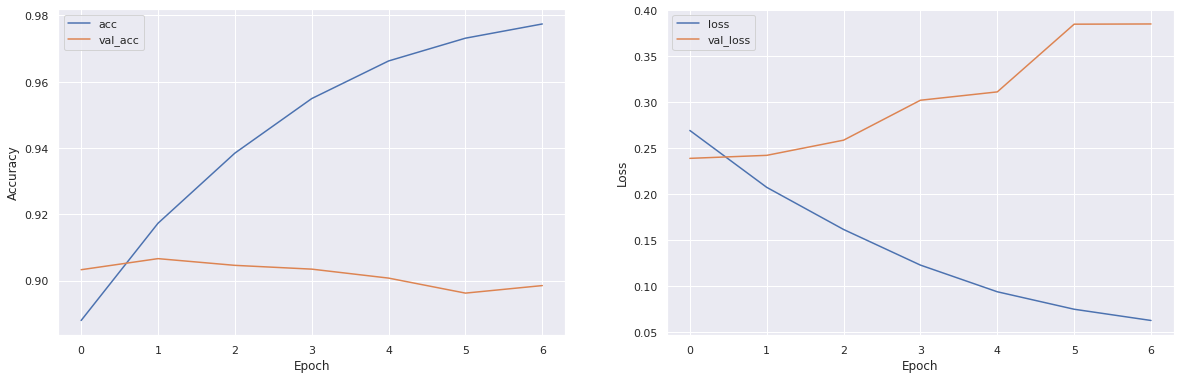

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(20, 6))
graph1 = fig.add_subplot(1, 2, 1)
graph2 = fig.add_subplot(1, 2, 2)

ax1 = sns.lineplot(data=acc, label='acc', ax=graph1)
sns.lineplot(data=val_acc, label='val_acc', ax=graph1)
ax2 = sns.lineplot(data=loss, label='loss', ax=graph2)
sns.lineplot(data=val_loss, label='val_loss', ax=graph2)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show()

# 모델 평가

위 train 데이터의 전처리와 동일하게 진행

In [ ]:
SEQ_LEN = 128

token_ids =[]
token_masks =[]
token_segments =[]

test_labels = []


for idx in tqdm(range(len(X_test))):
  
  test_sentence = X_test.iloc[idx]
    
  # 특수문자 제거
  cleaned_sentence = re.sub('[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', '', test_sentence)

  # Tokenizing / Tokens to sequence numbers / Padding
  encoded_dict = tokenizer.encode_plus(text=cleaned_sentence,
                                       padding='max_length', 
                                       truncation = True,
                                       max_length=SEQ_LEN)

  token_ids.append(encoded_dict['input_ids']) # tokens_tensor
  token_masks.append(encoded_dict['attention_mask']) # masks_tensor
  token_segments.append(encoded_dict['token_type_ids']) # segments_tensor

  test_labels.append(y_test.iloc[idx])

  
test_inputs = (np.array(token_ids), np.array(token_masks), np.array(token_segments))
test_labels = np.array(test_labels)

100%|██████████| 148197/148197 [00:46<00:00, 3202.14it/s]


In [ ]:
model.load_weights(filepath=CHECKPOINT_PATH + '/best_weights.h5')

pred = model.predict(test_inputs)
pred = tf.argmax(pred, axis=1)

print(accuracy_score(pred, y_test))

0.9071573648589377


# 모델 저장

In [ ]:
import pickle
import dill

with open(MODEL_PATH + '/model_v1.pkl', 'wb') as f:
  pickle.dump(dill.dumps(create_model), f)

# 배포 코드

Server-Side

In [1]:
from IPython.display import clear_output 

!pip install transformers
!pip install tensorflow_addons

clear_output()

In [2]:
from transformers import BertTokenizerFast, TFBertModel
import tensorflow as tf
import tensorflow_addons as tfa
import re
import numpy as np
import pickle
import dill

SEQ_LEN = 128
ROOT_PATH = '/content/drive/MyDrive/Project/DL'

CHECKPOINT_PATH = ROOT_PATH + '/saved_models'
MODEL_PATH = CHECKPOINT_PATH
CACHE_PATH = ROOT_PATH + '/cache'


def predict_sentiment(sentence, tokenizer, model):
  encoded_dict = tokenizer.encode_plus(text=re.sub('[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', '', sentence),
                                       padding='max_length', 
                                       truncation = True,
                                       max_length=SEQ_LEN)
  
  token_ids = np.array(encoded_dict['input_ids']).reshape(1, -1)
  token_masks = np.array(encoded_dict['attention_mask']).reshape(1, -1)
  token_segments = np.array(encoded_dict['token_type_ids']).reshape(1, -1)  

  return model.predict((token_ids, token_masks, token_segments))


# tokenizer
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base', cache_dir=CACHE_PATH)

# model
with open(MODEL_PATH + '/model_v1.pkl', 'rb') as f:
  create_model = dill.loads(pickle.load(f))

model = create_model(max_length=128)
model.load_weights(filepath=CHECKPOINT_PATH + '/best_weights.h5')

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Client-Side

In [3]:
def test(sentence):
  prediction = predict_sentiment(sentence, tokenizer, model) # function -> API
  predicted_probability = np.round(np.max(prediction) * 100, 2)
  predicted_class = ['부정', '긍정'][np.argmax(prediction, axis=1)[0]]
  print('{}: {}% 확률로 {}입니다.'.format(sentence, predicted_probability, predicted_class))

In [4]:
texts = [
         'GOTY',
         'GOD GAME',
         'TRASH GAME',
         '쿠소겜',
         'ㅆㄹㄱ',
         '가껨',
]

for text in texts:
  test(text)

GOTY: 90.35% 확률로 긍정입니다.
GOD GAME: 84.44% 확률로 긍정입니다.
TRASH GAME: 77.73% 확률로 부정입니다.
쿠소겜: 74.0% 확률로 부정입니다.
ㅆㄹㄱ: 70.72% 확률로 부정입니다.
가껨: 74.86% 확률로 긍정입니다.
